# Importing required modules and dependencies


In [ ]:
!pip install umap-learn

In [ ]:
#to execute any cell in the file, this should be executed first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingRegressor

# Data Processing and Splitting

Load dataset and check for missing values

In [ ]:
#load the dataset in the memory
data = pd.read_csv("Electricity BILL.csv")
#check for missing values in the dataset
print(data.isna().sum())

Building_Type                  0
Construction_Year              0
Number_of_Floors               0
Energy_Consumption_Per_SqM     0
Water_Usage_Per_Building       0
Waste_Recycled_Percentage      0
Occupancy_Rate                 0
Indoor_Air_Quality             0
Smart_Devices_Count            0
Green_Certified                0
Maintenance_Resolution_Time    0
Building_Status                0
Maintenance_Priority           0
Energy_Per_SqM                 0
Number_of_Residents            0
Electricity_Bill               0
dtype: int64


There are no missing values, so we just split data into features and labels

In [ ]:
#splitting data into target, categorical features and non-categorical features
target = data['Electricity_Bill'].values
features = data.drop(columns = 'Electricity_Bill')
categorical_columns = ['Building_Type', 'Green_Certified', 'Building_Status', 'Maintenance_Priority']
categorical_features = data[categorical_columns]
non_categorical_features = data.drop(columns=categorical_columns)

# a) EDA

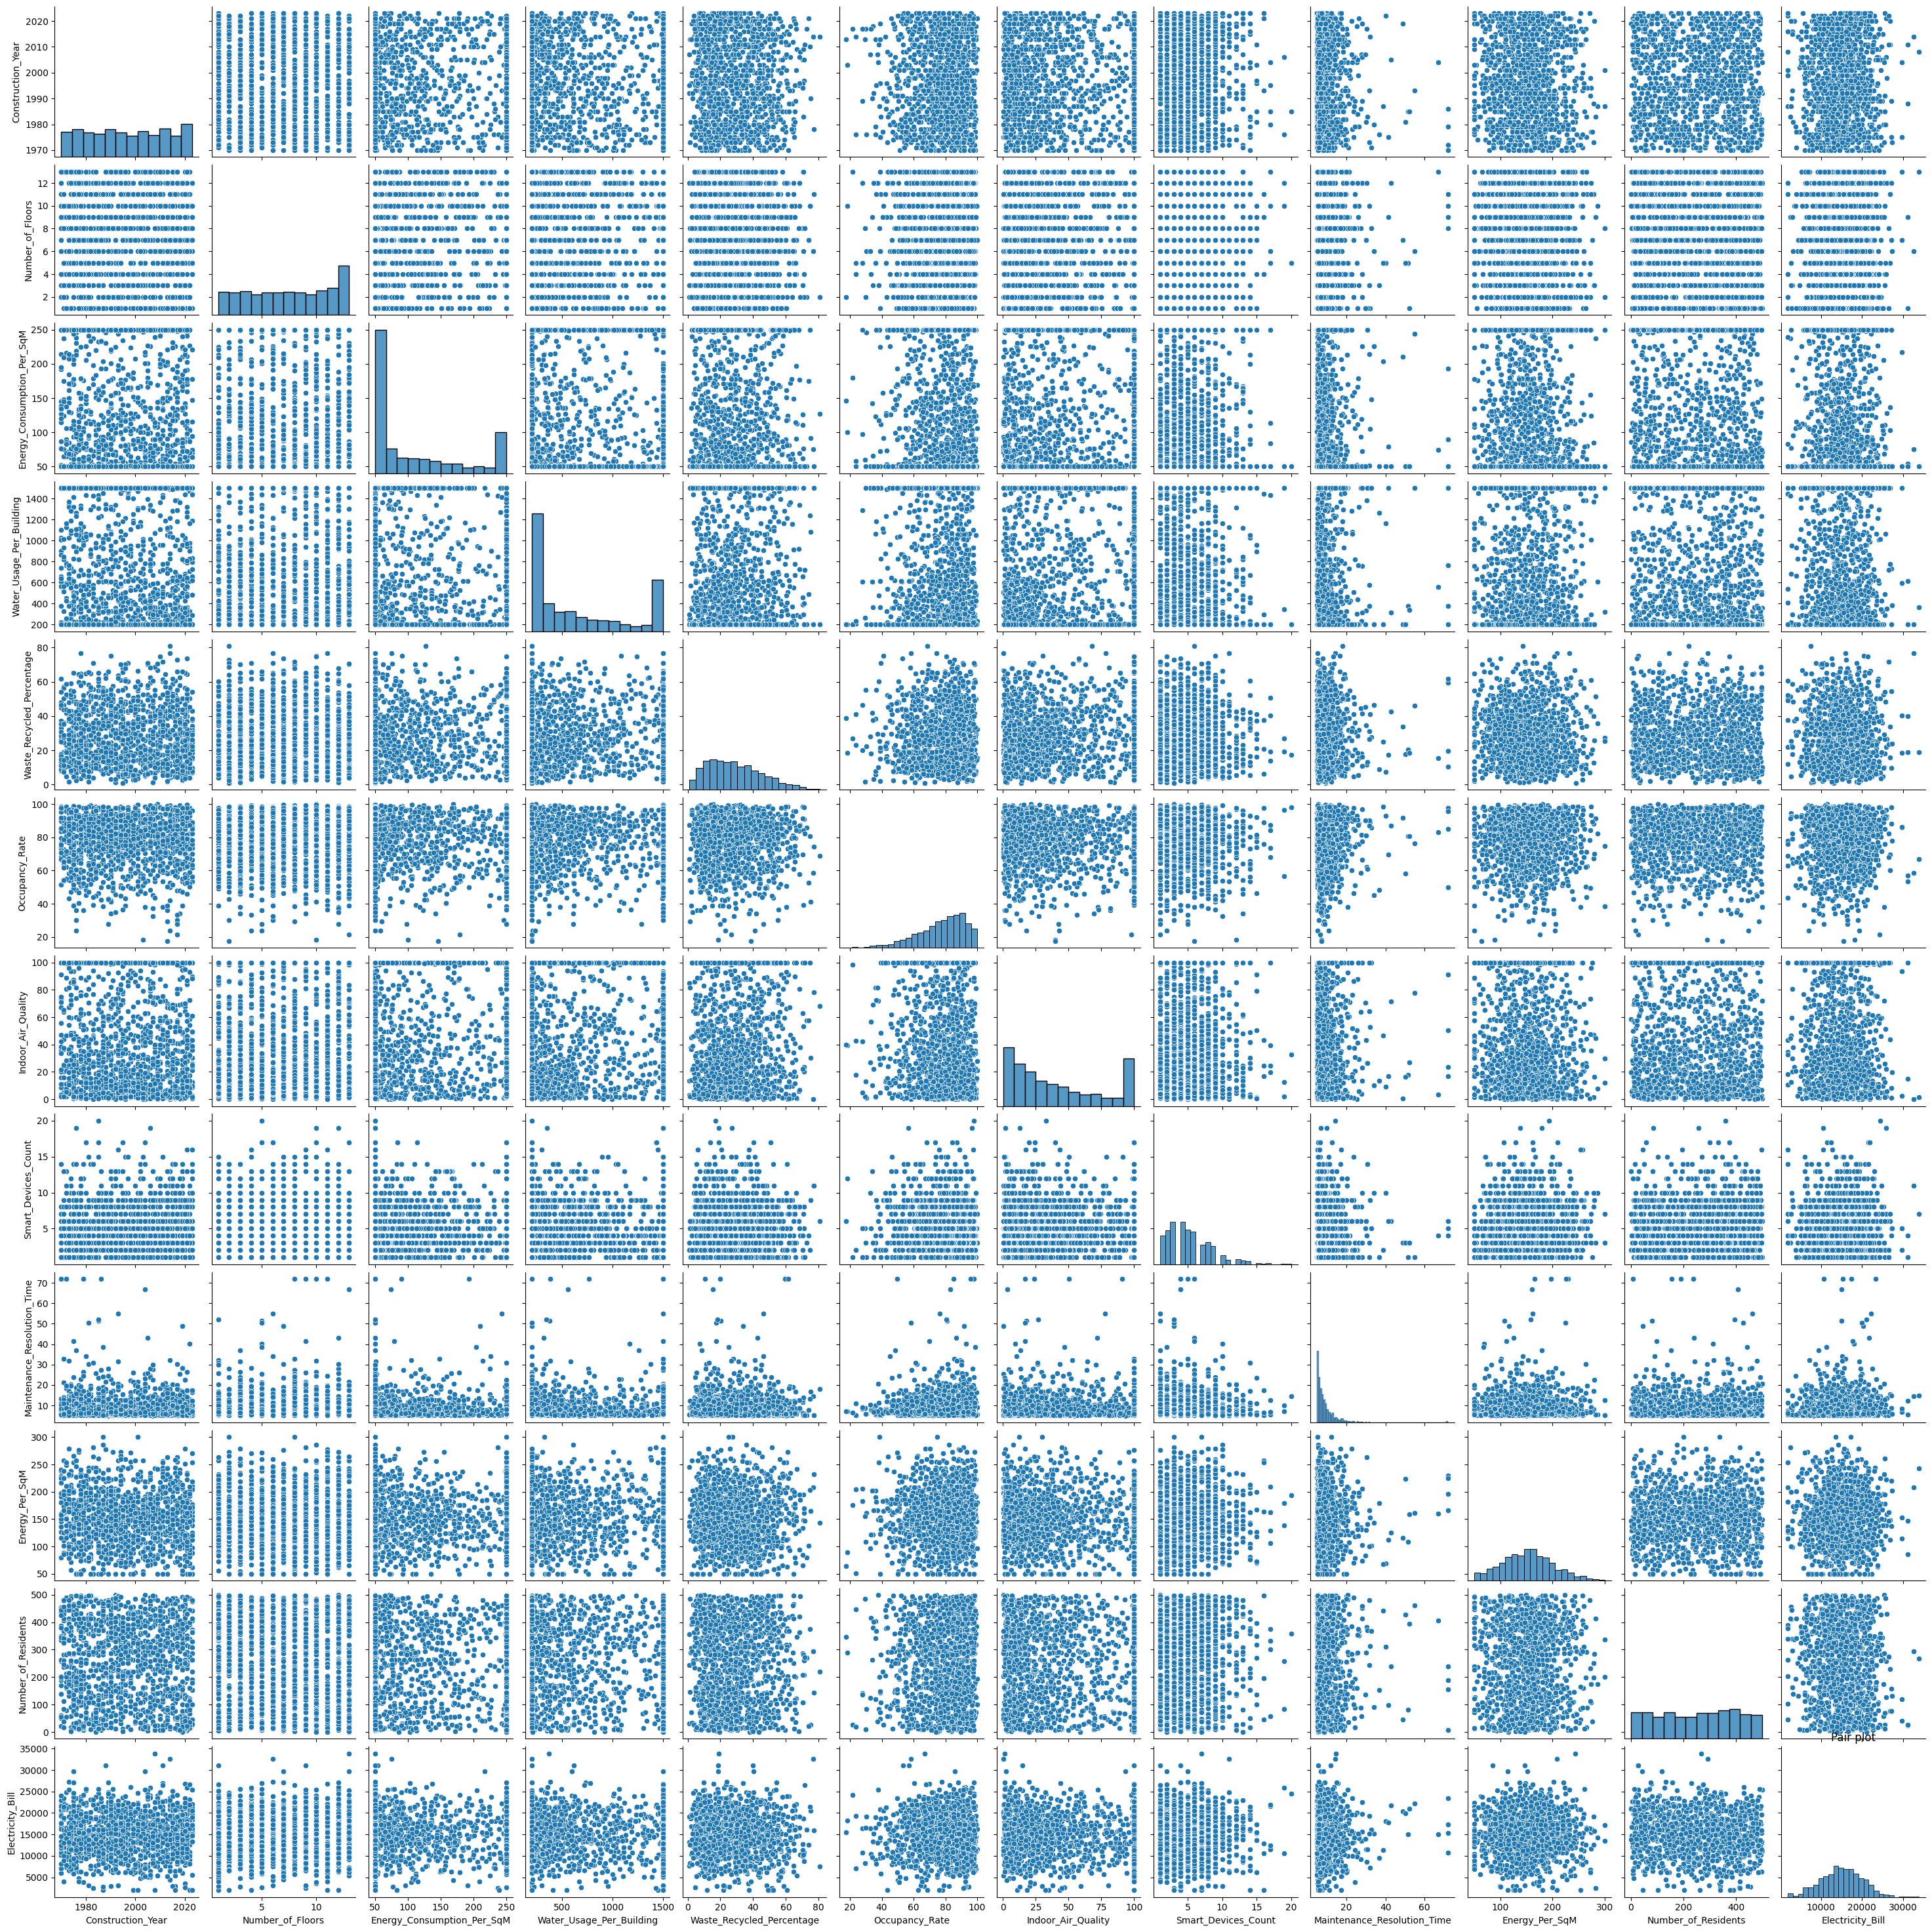

In [ ]:
#pair plots for non-categorical features
sns.pairplot(non_categorical_features)
plt.title('Pair plot')
plt.show()

All pair plots wrt Electricity_Bill have many scattered points, which means they won't be very helpful in model training and predictions.

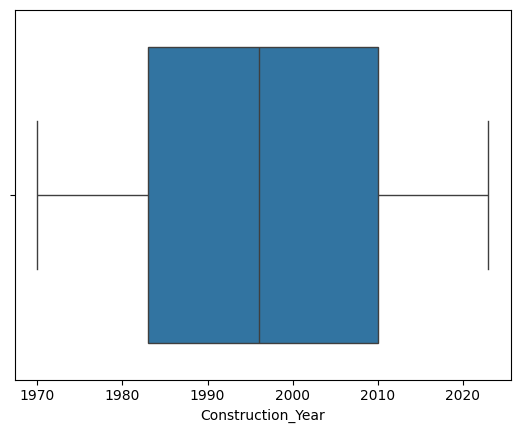

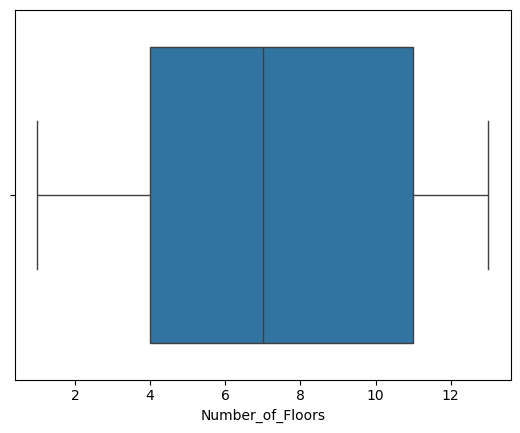

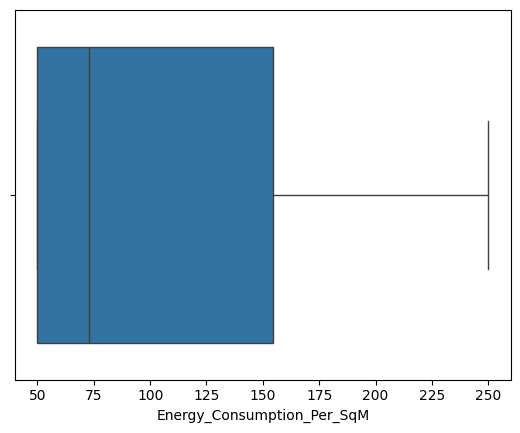

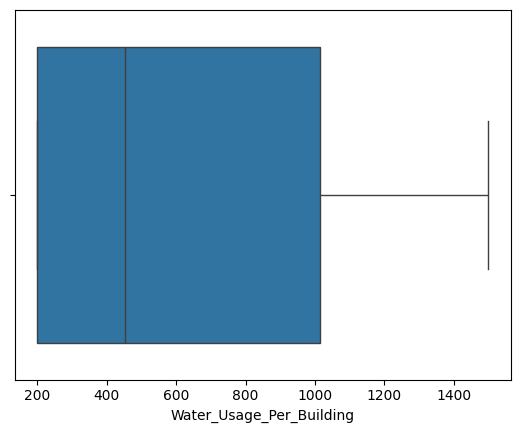

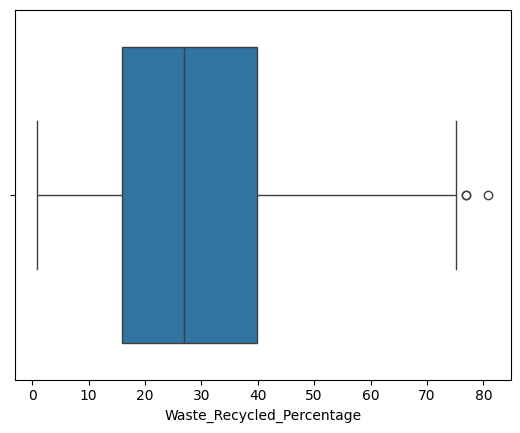

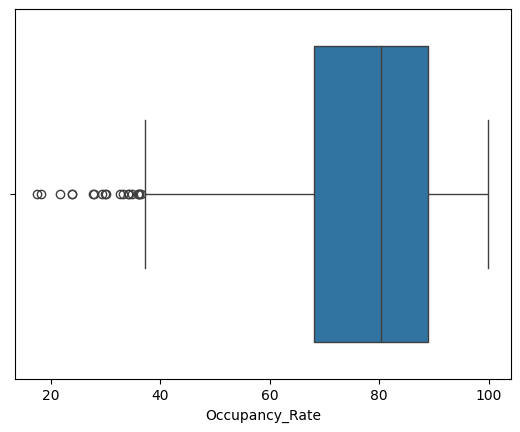

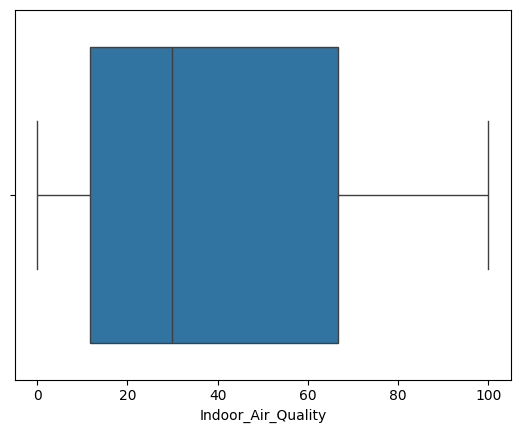

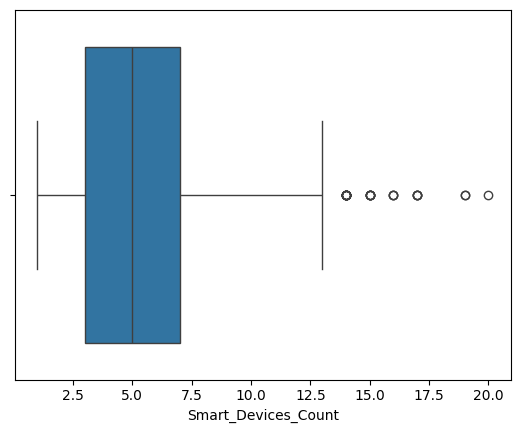

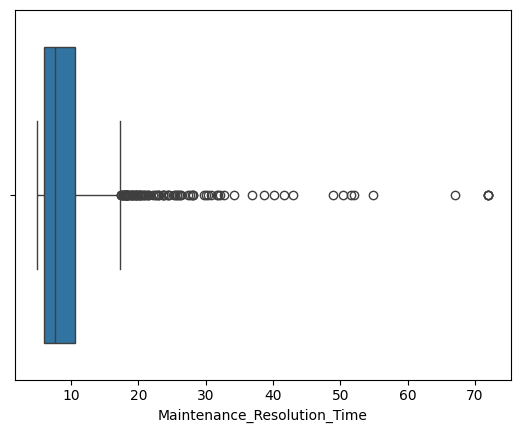

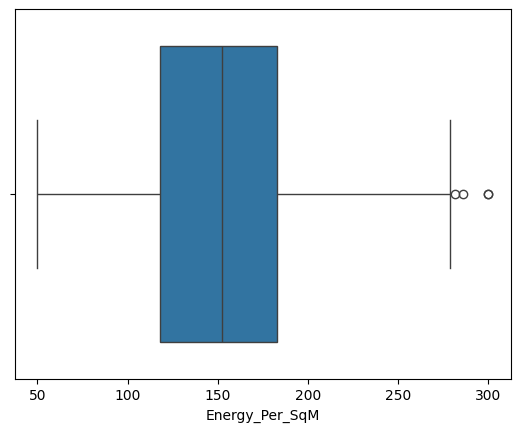

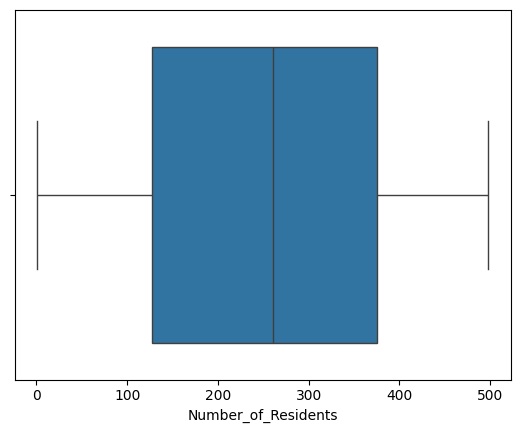

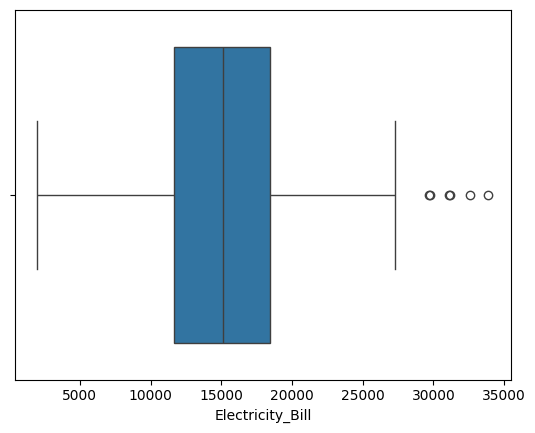

In [ ]:
#box plots for non-categorical features
for column in non_categorical_features.columns:
    sns.boxplot(x=non_categorical_features[column])
    plt.show()

Box plots show that Maintenance_Resolution_Time and Occupancy_Rate have a lot of outliers.

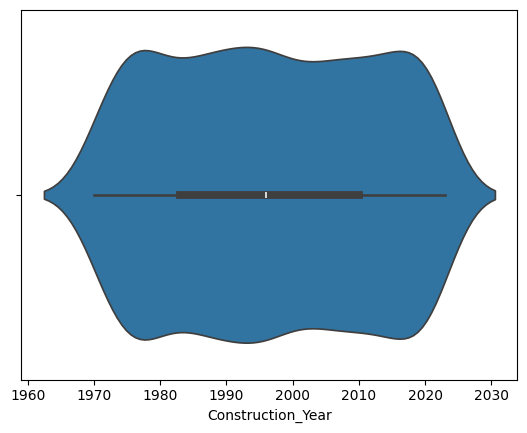

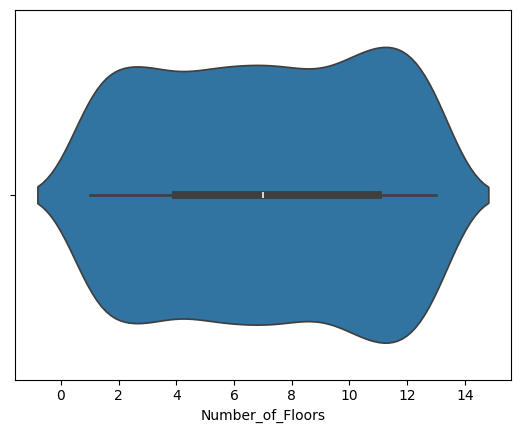

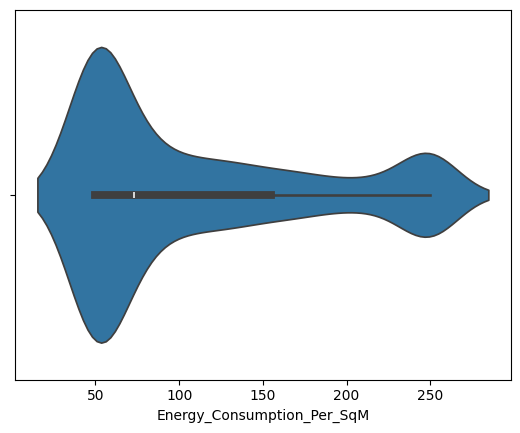

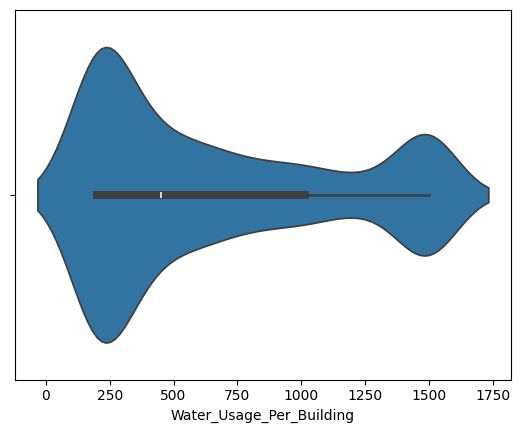

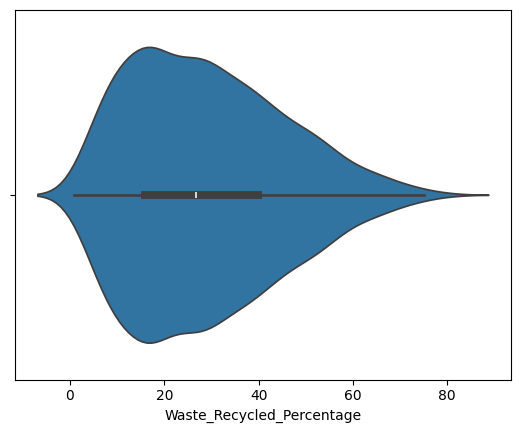

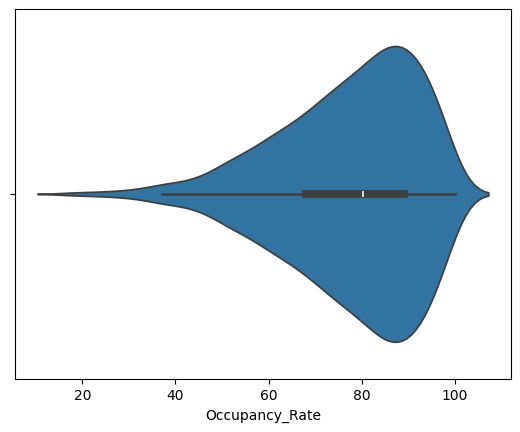

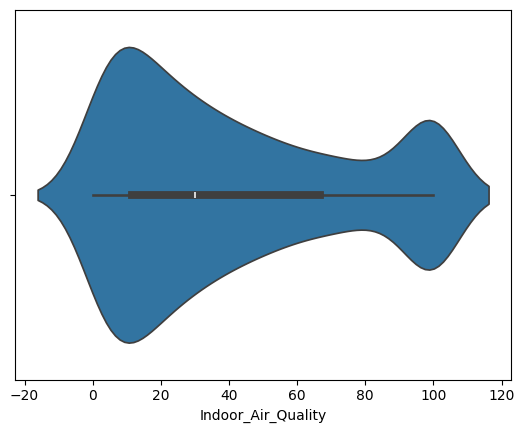

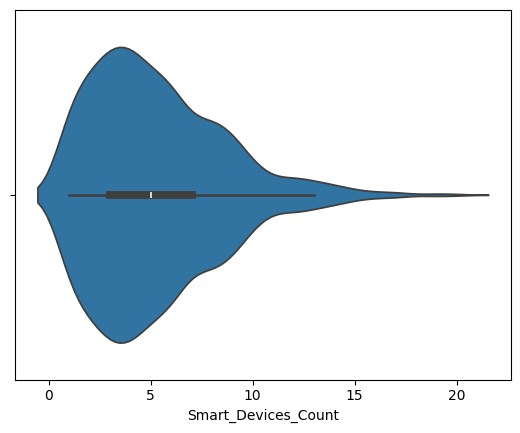

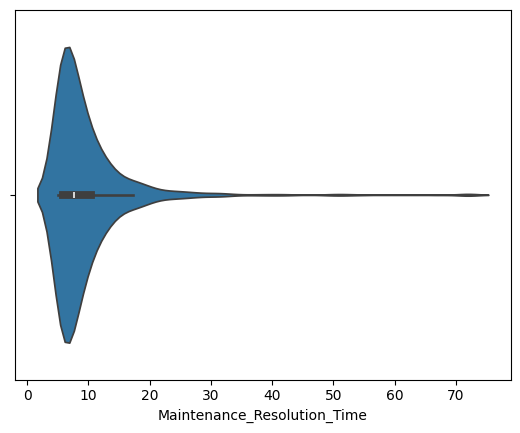

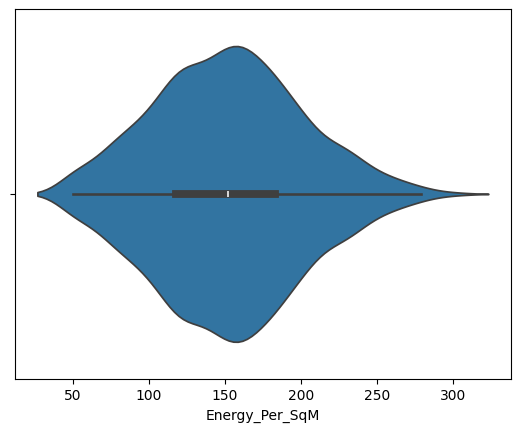

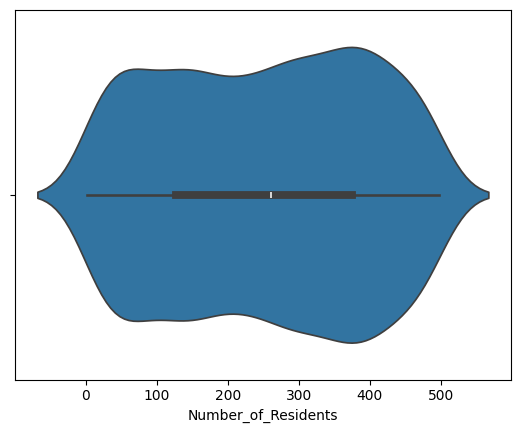

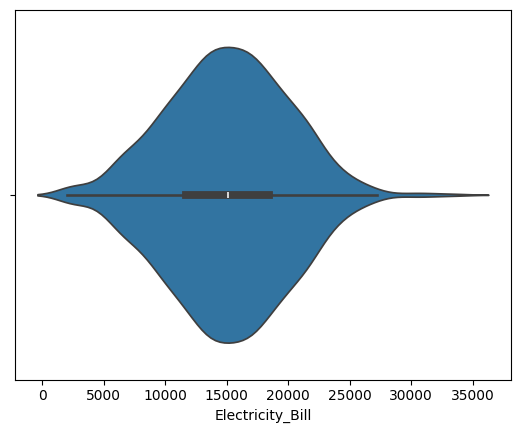

In [ ]:
#violin plots for non-categorical features
for column in non_categorical_features.columns:
    sns.violinplot(x=non_categorical_features[column])
    plt.show()

Electricity_Bill, Maintenance_Resolution_Time, Occupancy_Rate and Smart_Devices_Count have skewed distributions because their violin plots have a longer tail on one side.

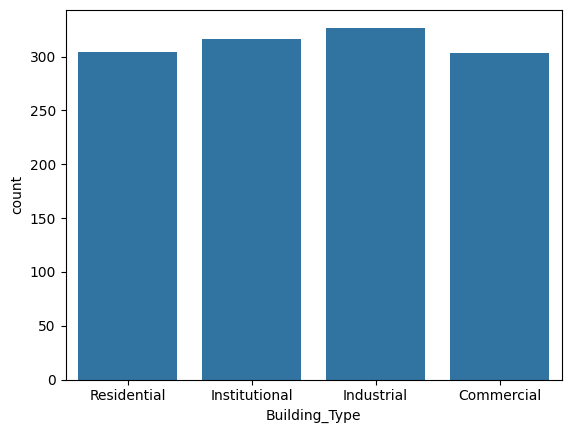

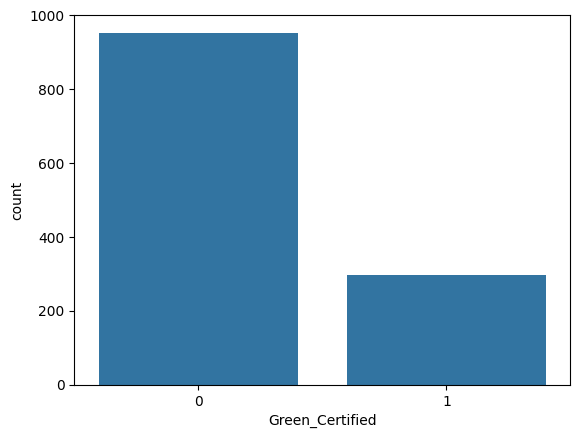

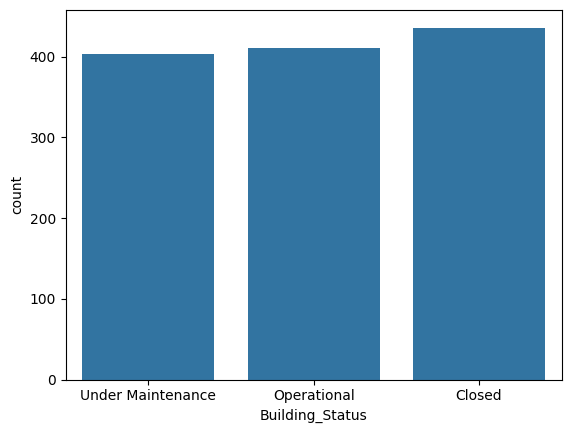

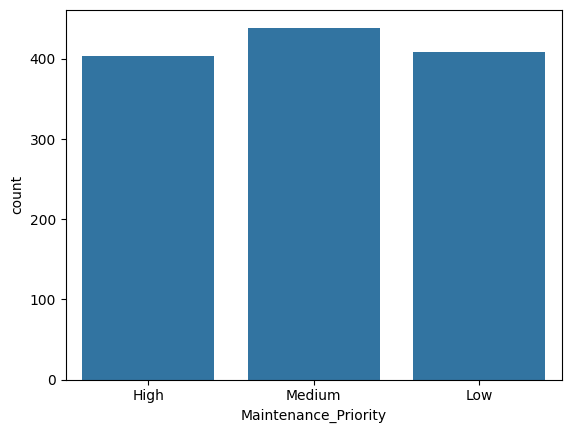

In [ ]:
#count plots for categorical features
for column in categorical_features.columns:
    sns.countplot(x=categorical_features[column])
    plt.show()

Count plots show that all categorical features except Green_certified are uniformly distributed.

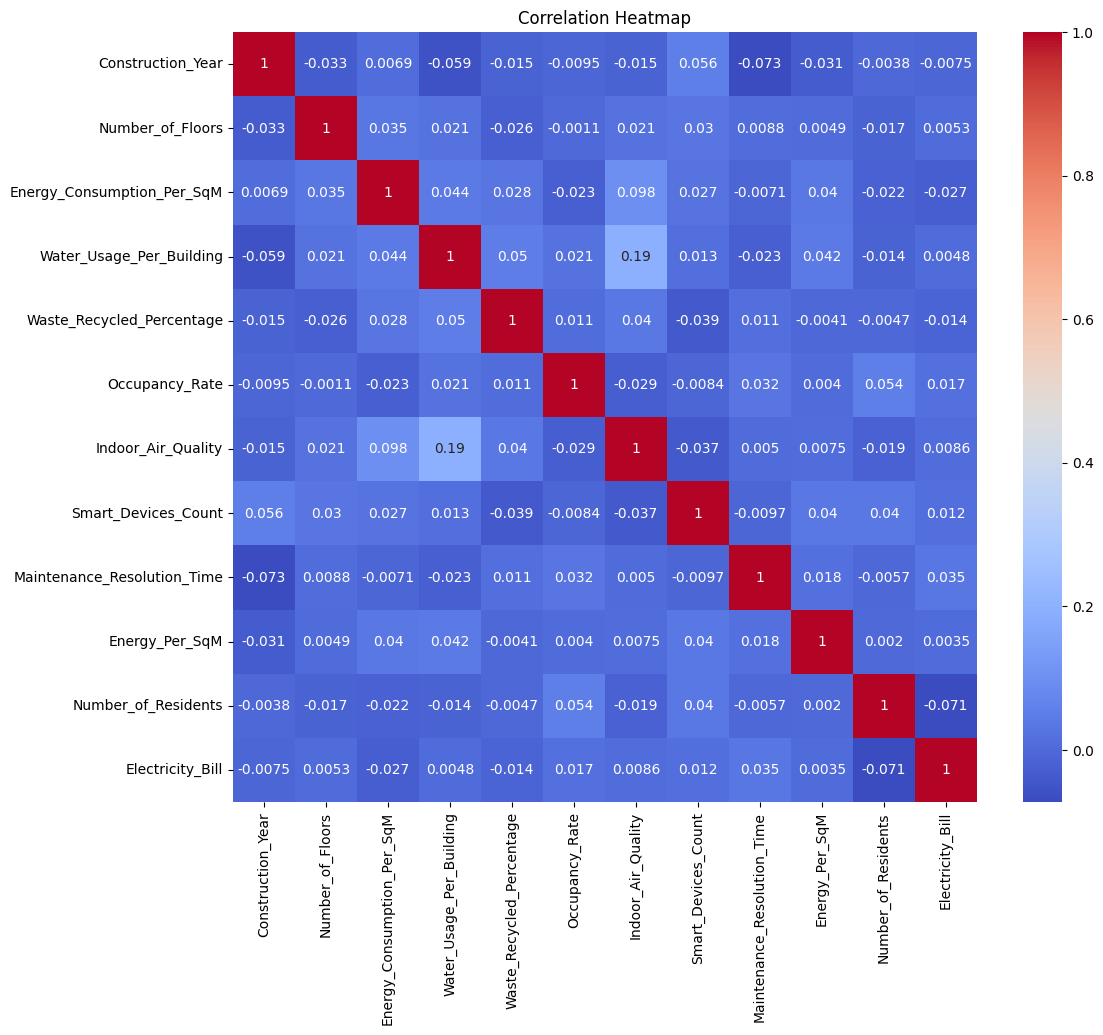

In [ ]:
#correlation heatmap for non-categorical features
plt.figure(figsize=(12, 10))
sns.heatmap(non_categorical_features.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The features are very weakly correlated with each other, the highest correlation we see is 0.19 between Indoor_Air Quality & Water_Usage_Building.

# b) Scatter plot after UMAP

1. Apply UMAP on non-categorical features

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


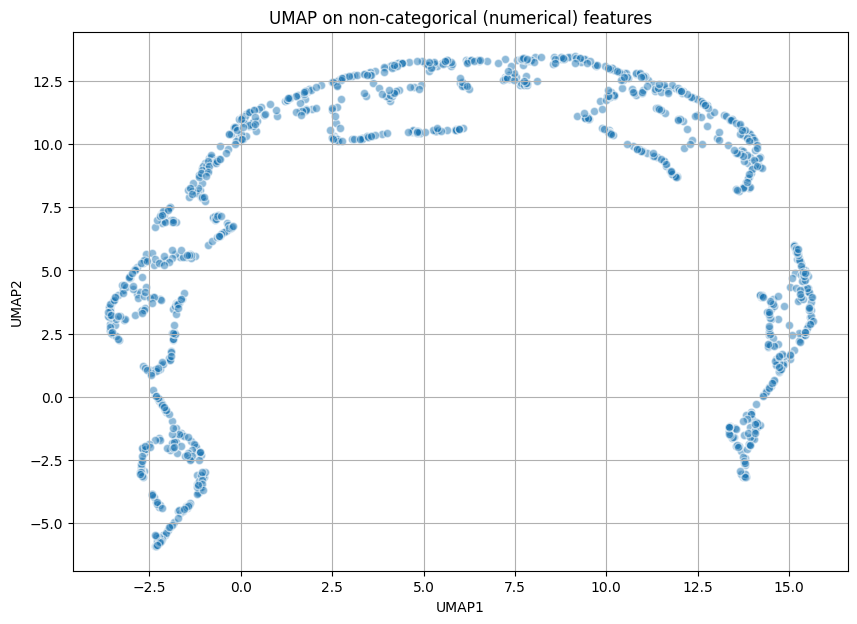

In [ ]:
#apply UMAP
reducer = umap.UMAP(n_components = 2, random_state = 42)
embedding = reducer.fit_transform(non_categorical_features)

#create a DataFrame for the embedding
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
#plotting
plt.figure(figsize=(10, 7))
plt.scatter(df['UMAP1'], df['UMAP2'], alpha=0.5, edgecolors='w')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP on non-categorical (numerical) features')
plt.grid(True)
plt.show()

The plot shows no clustering and no signs of separability.

2. Apply label encoding and UMAP on entire dataset

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


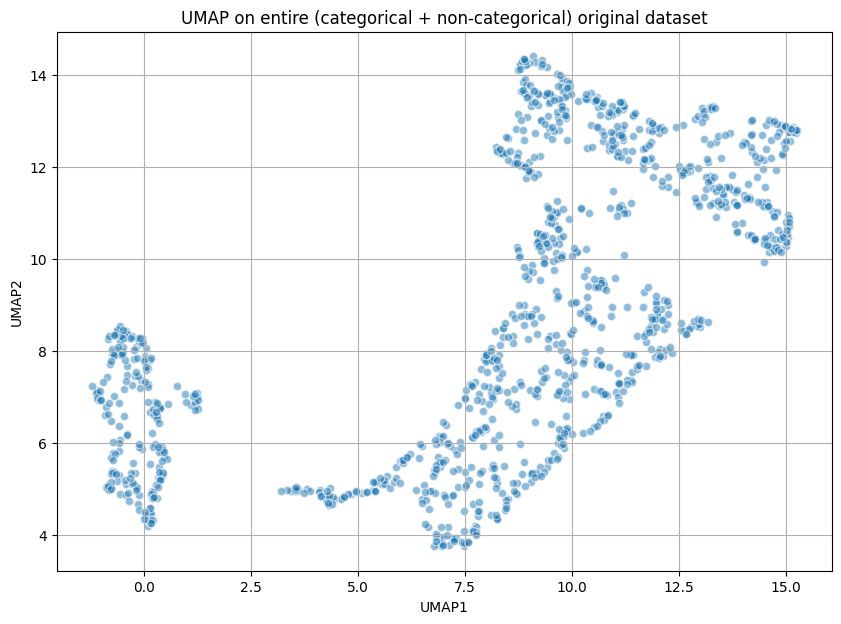

In [ ]:
labeled_features = features.copy()
#label encoding for categorical features
label_encoders = {}
for column in categorical_columns:
  le = LabelEncoder()
  labeled_features[column] = le.fit_transform(labeled_features[column])
  label_encoders[column] = le

#apply UMAP
reducer = umap.UMAP(n_components = 2, random_state = 42)
embedding = reducer.fit_transform(labeled_features)

#create a DataFrame for the embedding
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
#plotting
plt.figure(figsize=(10, 7))
plt.scatter(df['UMAP1'], df['UMAP2'], alpha=0.5, edgecolors='w')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP on entire (categorical + non-categorical) original dataset')
plt.grid(True)
plt.show()

The plot shows that data is separable but still clustering is not good.

3. Apply min-max scaling and umap on normalised dataset

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


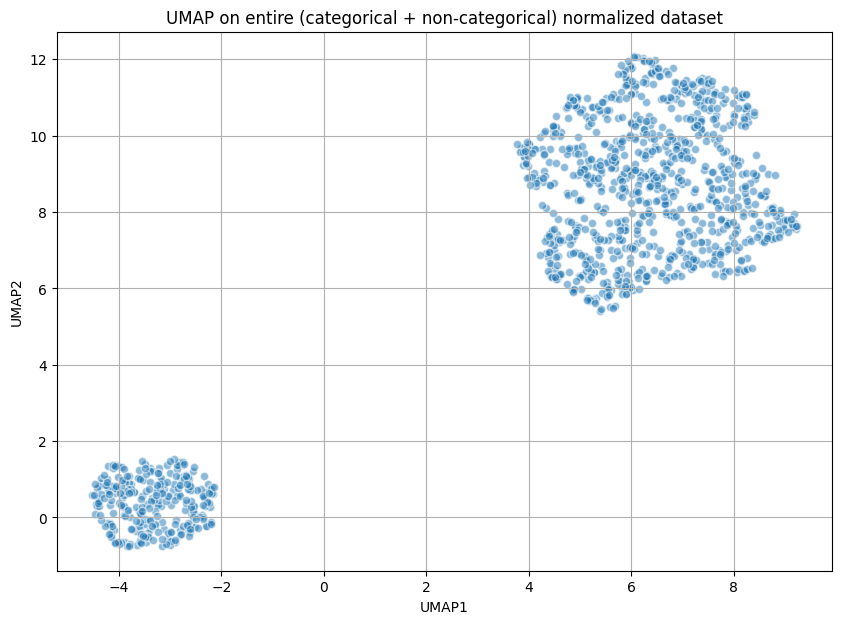

In [ ]:
#normalize numerical features
scaler = MinMaxScaler()
scaled_labeled_feature = scaler.fit_transform(labeled_features)
labeled_features[labeled_features.columns] = scaled_labeled_feature

#apply UMAP
reducer = umap.UMAP(n_components = 2, random_state = 42)
embedding = reducer.fit_transform(labeled_features)

#create a DataFrame for the embedding
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
#plotting
plt.figure(figsize=(10, 7))
plt.scatter(df['UMAP1'], df['UMAP2'], alpha=0.5, edgecolors='w')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP on entire (categorical + non-categorical) normalized dataset')
plt.grid(True)
plt.show()

The plot shows clear clustering and good separability. The separability and cluster size are directly dependent on the distribution of the Green_Certified feature.

# c) Applying linear regression

In [ ]:
#we have already checked for missing values in data processing and there were no na vlaues infact
#we already did label encoding for categorical features and normalized numerical values in part b

#dividing dataset into 80:20 (train:test)
x_train, x_test, y_train, y_test = train_test_split(labeled_features, target, test_size=0.2, random_state=42)

#apply linear regression
model_c = LinearRegression()
model_c.fit(x_train, y_train)

#make predictions
y_train_pred = model_c.predict(x_train)
y_test_pred = model_c.predict(x_test)

In [ ]:
#function to calculate and print metrics
def print_metrics(y_true, y_pred, x):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  n = x.shape[0] #sample size
  p = x.shape[1] #features
  adj_r2 = 1 - (1-r2) * (n-1) / (n-p-1)
  mae = mean_absolute_error(y_true, y_pred)
  print(f"MSE: {mse:.6f}, RMSE: {rmse:.6f}, R2: {r2:.6f}, Adjusted R2: {adj_r2:.6f}, MAE: {mae:.6f}\n")

print("Training metrics:")
print_metrics(y_train, y_train_pred, x_train) #training metrics
print("Testing metrics:")
print_metrics(y_test, y_test_pred, x_test) #testing metrics

Training metrics:
MSE: 24475013.168475, RMSE: 4947.222773, R2: 0.013923, Adjusted R2: -0.001109, MAE: 4006.328469

Testing metrics:
MSE: 24278016.155743, RMSE: 4927.272689, R2: 0.000037, Adjusted R2: -0.064063, MAE: 3842.409313



# d) Correlation Analysis

In [ ]:
#calculate correlation matrix on features (label encoded and normalised)
correlation_matrix = labeled_features.corrwith(pd.Series(target)).abs().sort_values(ascending=False)

#select the 3 most correlated features
corr_features = correlation_matrix.index[:3]
print("Top 3 Features: ", corr_features.values, "\n")

#filter the data using the 3 correlated features
x_train_3features = x_train[corr_features]
x_test_3features = x_test[corr_features]

#new LR model
model_d = LinearRegression()
model_d.fit(x_train_3features, y_train)

#make predictions
y_train_pred = model_d.predict(x_train_3features)
y_test_pred = model_d.predict(x_test_3features)

print("Training metrics:")
print_metrics(y_train, y_train_pred, x_train) #training metrics
print("Testing metrics:")
print_metrics(y_test, y_test_pred, x_test) #testing metrics

Top 3 Features:  ['Number_of_Residents' 'Green_Certified' 'Building_Type'] 

Training metrics:
MSE: 25633127.909369, RMSE: 5062.916937, R2: 0.007874, Adjusted R2: -0.009450, MAE: 4085.772104

Testing metrics:
MSE: 21790343.108056, RMSE: 4668.012758, R2: 0.005213, Adjusted R2: -0.036352, MAE: 3703.130351



The performance metrics in part c) and d) are only slightly different. We see that testing set MSE and MAE in d) are lesser than c) signifying model performs better after removing less important features.

# e) One-Hot encoding and Ridge

In [ ]:
#one-hot encode for categorical features on original dataset
hot1_features = pd.get_dummies(features, columns=categorical_columns)

#normalize numerical features
scaler = MinMaxScaler()
scaled_hot1_features = scaler.fit_transform(hot1_features)
hot1_features[hot1_features.columns] = scaled_hot1_features

#dividing dataset into 80:20 (train:test)
x_train, x_test, y_train, y_test = train_test_split(hot1_features, target, test_size=0.2, random_state=42)

#model for Ridge regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(x_train, y_train)

#make predictions
y_train_pred = ridge_model.predict(x_train)
y_test_pred = ridge_model.predict(x_test)

print("Training metrics:")
print_metrics(y_train, y_train_pred, x_train) #training metrics
print("Testing metrics:")
print_metrics(y_test, y_test_pred, x_test) #testing metrics

Training metrics:
MSE: 24189170.350024, RMSE: 4918.248708, R2: 0.025439, Adjusted R2: 0.002473, MAE: 3976.484672

Testing metrics:
MSE: 24119869.980905, RMSE: 4911.198426, R2: 0.006551, Adjusted R2: -0.094552, MAE: 3796.700550



The performance metrics in part c) and e) have still not improved much. We see that testing set MSE and MAE have improved slightly. Ridge regression is used to solve overfitting and no significant differences in metrics indicate that there is no overfitting in our model.

# f) ICA

In [ ]:
for n in [4,5,6,8]:
  #apply ICA to one-hot encoded features
  ica = FastICA(n_components=n, random_state=42)
  ica_features = ica.fit_transform(hot1_features)

  #dividing dataset into 80:20 (train:test)
  x_train, x_test, y_train, y_test = train_test_split(ica_features, target, test_size=0.2, random_state=42)

  #train Ridge regression model and predict
  ridge_model = Ridge(alpha=1.0)
  ridge_model.fit(x_train, y_train)
  y_train_pred = ridge_model.predict(x_train)
  y_test_pred = ridge_model.predict(x_test)

  print("\nResults for ", n, " ICA components: ")
  print("Training metrics:")
  print_metrics(y_train, y_train_pred, x_train) #training metrics
  print("Testing metrics:")
  print_metrics(y_test, y_test_pred, x_test) #testing metrics


Results for  4  ICA components: 
Training metrics:
MSE: 24664017.747731, RMSE: 4966.288126, R2: 0.006308, Adjusted R2: 0.002313, MAE: 4008.626465

Testing metrics:
MSE: 24429934.088252, RMSE: 4942.664675, R2: -0.006220, Adjusted R2: -0.022648, MAE: 3843.406824


Results for  5  ICA components: 
Training metrics:
MSE: 24662402.316144, RMSE: 4966.125483, R2: 0.006373, Adjusted R2: 0.001375, MAE: 4007.623820

Testing metrics:
MSE: 24457063.548279, RMSE: 4945.408330, R2: -0.007337, Adjusted R2: -0.027979, MAE: 3845.490059


Results for  6  ICA components: 
Training metrics:
MSE: 24657926.933578, RMSE: 4965.674872, R2: 0.006553, Adjusted R2: 0.000550, MAE: 4007.267720

Testing metrics:
MSE: 24503742.086319, RMSE: 4950.125462, R2: -0.009260, Adjusted R2: -0.034180, MAE: 3844.312378


Results for  8  ICA components: 
Training metrics:
MSE: 24407603.429804, RMSE: 4940.405189, R2: 0.016638, Adjusted R2: 0.008700, MAE: 3978.601023

Testing metrics:
MSE: 24048353.738371, RMSE: 4903.912085, R2: 0

As we increase the number of components, we see a slight decrease in train and test MAE. We alse see a slight increase in train R square error which means with increasing components the model complexity increases. But this doesn't provide much improvement and insight into model's performance.

# g) ElasticNet

In [ ]:
#dividing label encoded and normalised dataset (from part c) into 80:20 (train:test)
x_train, x_test, y_train, y_test = train_test_split(labeled_features, target, test_size=0.2, random_state=42)

#different values of alpha and l1_ratio to test
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]

for alpha in alpha_values:
  #initialize and train ElasticNet model with default l1_ratio = 0.5
  elastic_net_model = ElasticNet(alpha=alpha, random_state=42)
  elastic_net_model.fit(x_train, y_train)
  #predictions
  y_test_pred = elastic_net_model.predict(x_test)

  print(f"\nElasticNet with alpha={alpha}:")
  print("Testing metrics:")
  print_metrics(y_test, y_test_pred, x_test) #testing metrics


ElasticNet with alpha=0.1:
Testing metrics:
MSE: 24179392.906361, RMSE: 4917.254611, R2: 0.004099, Adjusted R2: -0.059740, MAE: 3831.727821


ElasticNet with alpha=0.5:
Testing metrics:
MSE: 24233436.978265, RMSE: 4922.746894, R2: 0.001873, Adjusted R2: -0.062109, MAE: 3831.919426


ElasticNet with alpha=1.0:
Testing metrics:
MSE: 24276861.557231, RMSE: 4927.155524, R2: 0.000085, Adjusted R2: -0.064012, MAE: 3835.424757


ElasticNet with alpha=2.0:
Testing metrics:
MSE: 24312795.461590, RMSE: 4930.800692, R2: -0.001395, Adjusted R2: -0.065587, MAE: 3838.272971


ElasticNet with alpha=5.0:
Testing metrics:
MSE: 24342155.658763, RMSE: 4933.777018, R2: -0.002604, Adjusted R2: -0.066874, MAE: 3840.554178



As we increase alpha, we see a slight increase in test MSE, R square error, MAE. This indicates that the model's performance degrades as we increase the alpha (controls overall regularization strength).


# h) Gradient Boosting Regressor

In [ ]:
#using the dataset from c) which was also used in g)

#initialize and train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gbr.fit(x_train, y_train)

#predict on train and test sets
y_train_pred = gbr.predict(x_train)
y_test_pred = gbr.predict(x_test)

print("Training metrics:")
print_metrics(y_train, y_train_pred, x_train) #training metrics
print("Testing metrics:")
print_metrics(y_test, y_test_pred, x_test) #testing metrics

Training metrics:
MSE: 14926446.257308, RMSE: 3863.475929, R2: 0.398626, Adjusted R2: 0.389459, MAE: 3092.748189

Testing metrics:
MSE: 24424706.773919, RMSE: 4942.135851, R2: -0.006005, Adjusted R2: -0.070492, MAE: 3820.286031



The training MSE is the least encountered so far in all model metrics indicating better performance on testing data. The test MAE and test MSE are more than part g) but less than part c) which means that even after gradient boosting model was not able to generalise well.